In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import UNet2DModel
from torchvision import datasets, transforms
from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


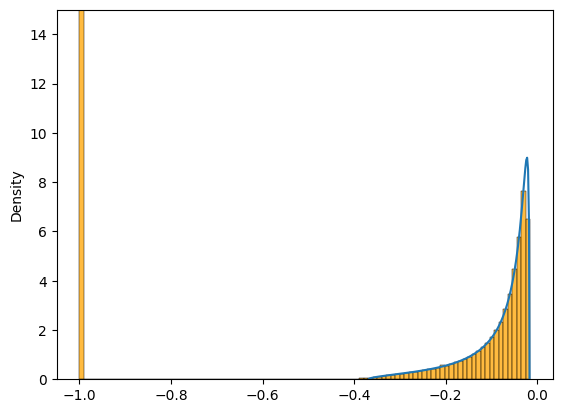

In [2]:
sigma = 1
dim_latent = 50
dim_ambiant = 100

t = 0.1

n = 1000

ev = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
    J_t = (
        (1/t) * F @ np.linalg.inv(np.eye(dim_latent) + (1/t) * F.T @ F ) @ F.T
        - np.eye(dim_ambiant)
    )
    ev = np.concatenate((ev, np.linalg.eigvals(J_t).real))


def rho(r, t, dim_ambiant, dim_latent):
    alpha_m = dim_latent / dim_ambiant

    lambda_plus = (1 + 1/np.sqrt(alpha_m))**2
    lambda_minus = (1 - 1/np.sqrt(alpha_m))**2
    
    r_plus = -t / (lambda_plus + t)
    r_minus = -t / (lambda_minus + t) 
    
    r_valid = (r > r_minus) & (r < r_plus)
    r = r[r_valid]
    r = np.concatenate((np.array([r_minus]), r, np.array([r_plus])))
    
    density = - (alpha_m / (2 * np.pi)) * (1 / (r * (1 + r))) * \
        np.sqrt((lambda_plus - (-t - (t / r))) * ((-t - (t / r)) - lambda_minus))
    
    return density, r

x = np.linspace(-2, 0, 1000)
y, x_valid = rho(x, t=t, dim_ambiant=dim_ambiant, dim_latent=dim_latent)
plt.plot(x_valid, y)
sns.histplot(ev, stat="density", bins=100, color='orange')
# ev[ev < -0.999] = 0
# sns.kdeplot(ev, bw_adjust=1, color='red')
# plt.hist(ev, density=True, bins=50, color='orange')
# plt.xlim((-1.25, 0.25))
plt.ylim((0, 15))
plt.show()

[WARNING - spectral_law]: Setting ratio >= 1.0 may cause numerical instability. Provided ratio = 2.0.


t = 10.0...
t = 1...
t = 0.01...


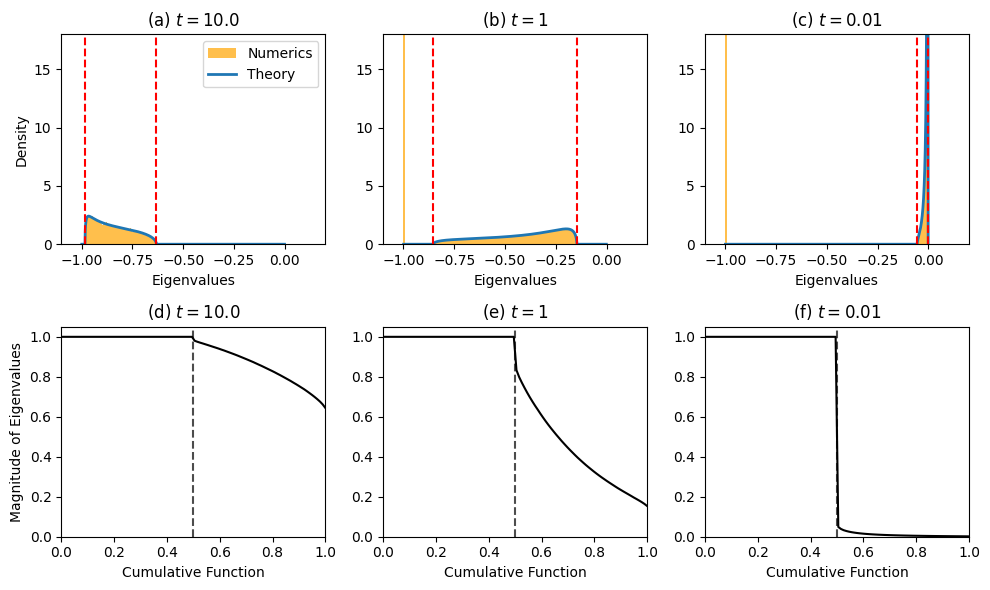

In [3]:
sigma = 1.0
dim_latent = 50  
dim_ambiant = 100 
alpha = dim_latent / dim_ambiant 
n = 1000         

T = [10.0, 1, 0.01] 

MP = MarchenkoPasturDistribution(ratio=dim_ambiant / dim_latent, sigma=sigma)

def panel_label(k):
    return chr(ord('a') + k)


def r_edges(t, alpha):
    s = np.sqrt(alpha)**(-1)
    r_plus  = -t / ((1 - s)**2 + t)  
    r_minus = -t / ((1 + s)**2 + t) 
    return r_minus, r_plus


fig, axes = plt.subplots(2, len(T), figsize=(10, 6))

for i, t in enumerate(T):
    print(f"t = {t}...")

    ev = []
    all_eigs = []

    for _ in range(n):
        F = (sigma / np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
        FtF = F.T @ F
        J_t = (1/t) * F @ np.linalg.solve(np.eye(dim_latent) + (1/t) * FtF, F.T) - np.eye(dim_ambiant)
        eigs = np.linalg.eigvalsh(J_t)
        ev.append(eigs)
        all_eigs.append(eigs)

    all_eigs = np.array(all_eigs)
    ev = all_eigs.flatten()

    r_grid = np.linspace(-0.999, -1e-3, 4000)

    gamma = -t - (t / r_grid)
    rho_r = (t / (r_grid**2)) * MP.pdf(gamma)

    r_min, r_max = r_edges(t, alpha)


    ax_top = axes[0, i]
    ax_top.hist(ev, bins=150, density=True, color='orange', alpha=0.7, label='Numerics')
    ax_top.plot(r_grid, rho_r, lw=2, label='Theory') 
    ax_top.axvline(r_min, ls='--', lw=1.5, color='r')
    ax_top.axvline(r_max, ls='--', lw=1.5, color='r')

    ax_top.set_title(f"({panel_label(i)}) $t = {t}$")
    ax_top.set_xlim(-1.1, 0.2)
    ax_top.set_ylim(0, 18)
    ax_top.set_xlabel("Eigenvalues")
    if i == 0:
        ax_top.set_ylabel("Density")
        ax_top.legend()



    ax_bot = axes[1, i]
    sorted_per_run = np.sort(np.abs(all_eigs), axis=1)[:, ::-1]
    mean_sorted_mag = np.mean(sorted_per_run, axis=0)
    mean_sorted_mag_normalized = mean_sorted_mag / np.max(mean_sorted_mag)
    cumulative_x = np.linspace(0, 1, dim_ambiant)

    ax_bot.plot(cumulative_x, mean_sorted_mag_normalized, lw=1.5, color='black')
    ax_bot.axvline(x=alpha, ls='--', alpha=0.7, color='k')  

    ax_bot.set_xlim(0, 1.0)
    ax_bot.set_ylim(0, 1.05)
    ax_bot.set_xlabel("Cumulative Function")
    ax_bot.set_title(f"({panel_label(len(T) + i)}) $t = {t}$")
    if i == 0:
        ax_bot.set_ylabel("Magnitude of Eigenvalues")

plt.tight_layout()
plt.show()


### **Théorie : Équation Fondamentale du Modèle Double Variance (Eq. 56)**

La densité spectrale $\rho(\gamma)$ est déterminée par la méthode des répliques. On cherche la racine physique $q^*$ de l'équation cubique suivante :

$$z q^3 + q^2 \left( \alpha_m - 1 - \frac{z\alpha_m }{\sigma_1^2} - \frac{z\alpha_m }{\sigma_2^2} \right) + q \left( \frac{\alpha_m^2}{\sigma_1^2 \sigma_2^2} (z - f \sigma_1^2 - (1-f) \sigma_2^2) + \frac{\alpha_m }{\sigma_1^2} + \frac{\alpha_m }{\sigma_2^2} \right) - \frac{\alpha_m^2}{\sigma_1^2 \sigma_2^2} = 0$$

Où les coefficients sont définis par les paramètres du modèle $\alpha_m = m/d$, la fraction $f$, et les variances $\sigma_1^2, \sigma_2^2$

La densité spectrale finale $\rho(\gamma)$ est extraite de la partie imaginaire de la racine $q^*$ pour un petit paramètre de régularisation $\epsilon \to 0$ ($z = \gamma - i\epsilon$) :

$$\rho(\gamma) = \frac{\alpha_m}{\pi} \lim_{\epsilon \to 0^+} \text{Im}[q^*]$$

In [4]:
def compute_spectrum(gamma_vals, alpha, f, s1, s2, eps=1e-12):
    """"Distribution asymptotique des valeurs propres via la transformée de Stieltjes"""
    rho = np.zeros_like(gamma_vals)
    
    for idx, gamma in enumerate(gamma_vals):
        z = gamma - 1j * eps
        
        c3 = z
        c2 = alpha - 1 - z*alpha/s1 - z*alpha/s2
        c1 = (alpha**2 / (s1*s2)) * (z - f*s1 - (1-f)*s2) + alpha/s1 + alpha/s2
        c0 = -alpha**2 / (s1*s2)
        
        roots = np.roots([c3, c2, c1, c0])
        valid_roots = [r for r in roots if r.imag > 1e-15]
        
        if valid_roots:
            q_star = max(valid_roots, key=lambda x: x.imag)
            rho[idx] = (alpha / np.pi) * q_star.imag
    
    return rho/alpha

def compute_rho(gamma, alpha, f, s1, s2, eps=1e-12):
    """Calcule rho pour une seule valeur de gamma"""
    z = gamma - 1j * eps
    
    # coefficients de l'equation 56
    c3 = z
    c2 = alpha - 1 - z*alpha/s1 - z*alpha/s2
    c1 = (alpha**2 / (s1*s2)) * (z - f*s1 - (1-f)*s2) + alpha/s1 + alpha/s2
    c0 = -alpha**2 / (s1*s2)
    
    roots = np.roots([c3, c2, c1, c0])
    valid_roots = [r for r in roots if r.imag > 0]
    
    if valid_roots:
        q_star = max(valid_roots, key=lambda x: x.imag)
        return (alpha / np.pi) * q_star.imag
    return 0.0

def find_gap_bounds(alpha, f, s1, s2, gamma_search_min=0.01, gamma_search_max=5.0, n_points=10000):
    """Trouve gamma_minus et gamma_plus numériquement"""
    gamma_vals = np.linspace(gamma_search_min, gamma_search_max, n_points)
    rho_vals = np.array([compute_rho(g, alpha, f, s1, s2) for g in gamma_vals])
    
    # Trouver le minimum local (position du gap)
    # D'abord trouver le max du premier pic
    peak1_idx = np.argmax(rho_vals[:n_points//4])
    
    # Puis chercher le minimum après ce pic
    search_start = peak1_idx + 100
    search_end = n_points // 2
    min_idx = search_start + np.argmin(rho_vals[search_start:search_end])
    
    gamma_gap = gamma_vals[min_idx]
    rho_min = rho_vals[min_idx]
    
    # Seuil pour définir les bornes (là où rho tombe proche du minimum)
    threshold = rho_min + 0.005
    
    # gamma_minus : dernière position avant le gap où rho > threshold
    left_region = gamma_vals[:min_idx]
    rho_left = rho_vals[:min_idx]
    above_threshold_left = np.where(rho_left > threshold)[0]
    if len(above_threshold_left) > 0:
        gamma_minus = left_region[above_threshold_left[-1]]
    else:
        gamma_minus = gamma_gap
    
    # gamma_plus : première position après le gap où rho > threshold
    right_region = gamma_vals[min_idx:]
    rho_right = rho_vals[min_idx:]
    above_threshold_right = np.where(rho_right > threshold)[0]
    if len(above_threshold_right) > 0:
        gamma_plus = right_region[above_threshold_right[0]]
    else:
        gamma_plus = gamma_gap
    
    return gamma_minus, gamma_plus

def transform_spectrum_to_J(gamma_vals, rho_gamma, t):
    r_vals = -t / (t + gamma_vals + 1e-15)
    
    jacobian = ((t + gamma_vals)**2) / t
    rho_r = rho_gamma * jacobian

    sort_indices = np.argsort(r_vals)
    r_vals = r_vals[sort_indices]
    rho_r = rho_r[sort_indices]
    
    return r_vals, rho_r

# cette fonction permet de calculer les bounds que lorsque s1 >> s2
def transform_bounds_to_J_approx(gamma_minus, gamma_plus, t):
    r_minus = -t / (t + gamma_minus)
    r_plus = -t / (t + gamma_plus)
    return r_minus, r_plus

# Figure 8

gamma_minus = 0.3578
gamma_plus = 0.5639


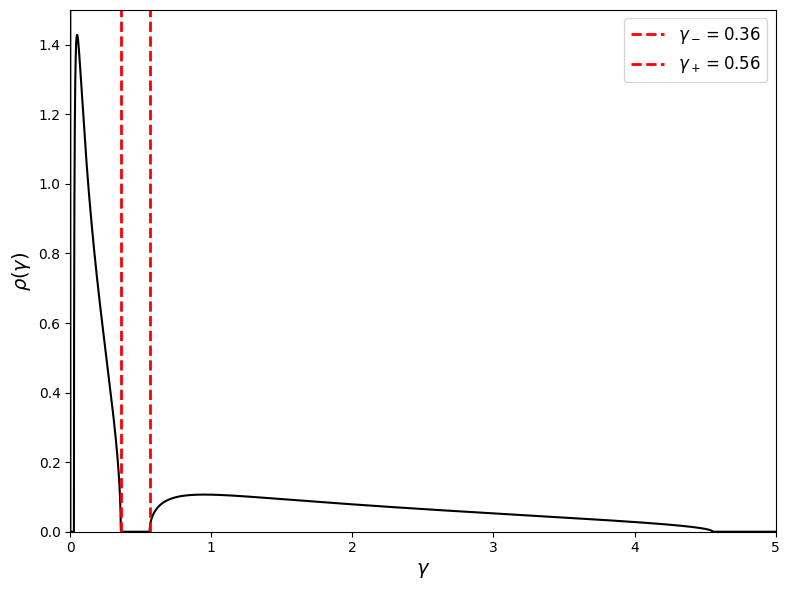

In [5]:
# Test
alpha = 0.5
f = 0.5
s1 = 1.0
s2 = 0.1

gamma_minus, gamma_plus = find_gap_bounds(alpha, f, s1, s2)
print(f"gamma_minus = {gamma_minus:.4f}")
print(f"gamma_plus = {gamma_plus:.4f}")

# Plot
gamma_vals = np.linspace(0, 5, 100000)
rho = compute_spectrum(gamma_vals, alpha, f, s1, s2)

plt.figure(figsize=(8, 6))
plt.plot(gamma_vals, rho, 'k-', linewidth=1.5)
plt.axvline(x=gamma_minus, color='red', linestyle='--', linewidth=2, label=rf'$\gamma_- = {gamma_minus:.2f}$')
plt.axvline(x=gamma_plus, color='red', linestyle='--', linewidth=2, label=rf'$\gamma_+ = {gamma_plus:.2f}$')
plt.xlabel(r'$\gamma$', fontsize=14)
plt.ylabel(r'$\rho(\gamma)$', fontsize=14)
plt.xlim(0, 5)
plt.ylim(0, 1.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Figure 2

Bornes gamma: [0.0260, 0.3034]
t = 10...
t = 0.1...
t = 0.01...
t = 0.0005...


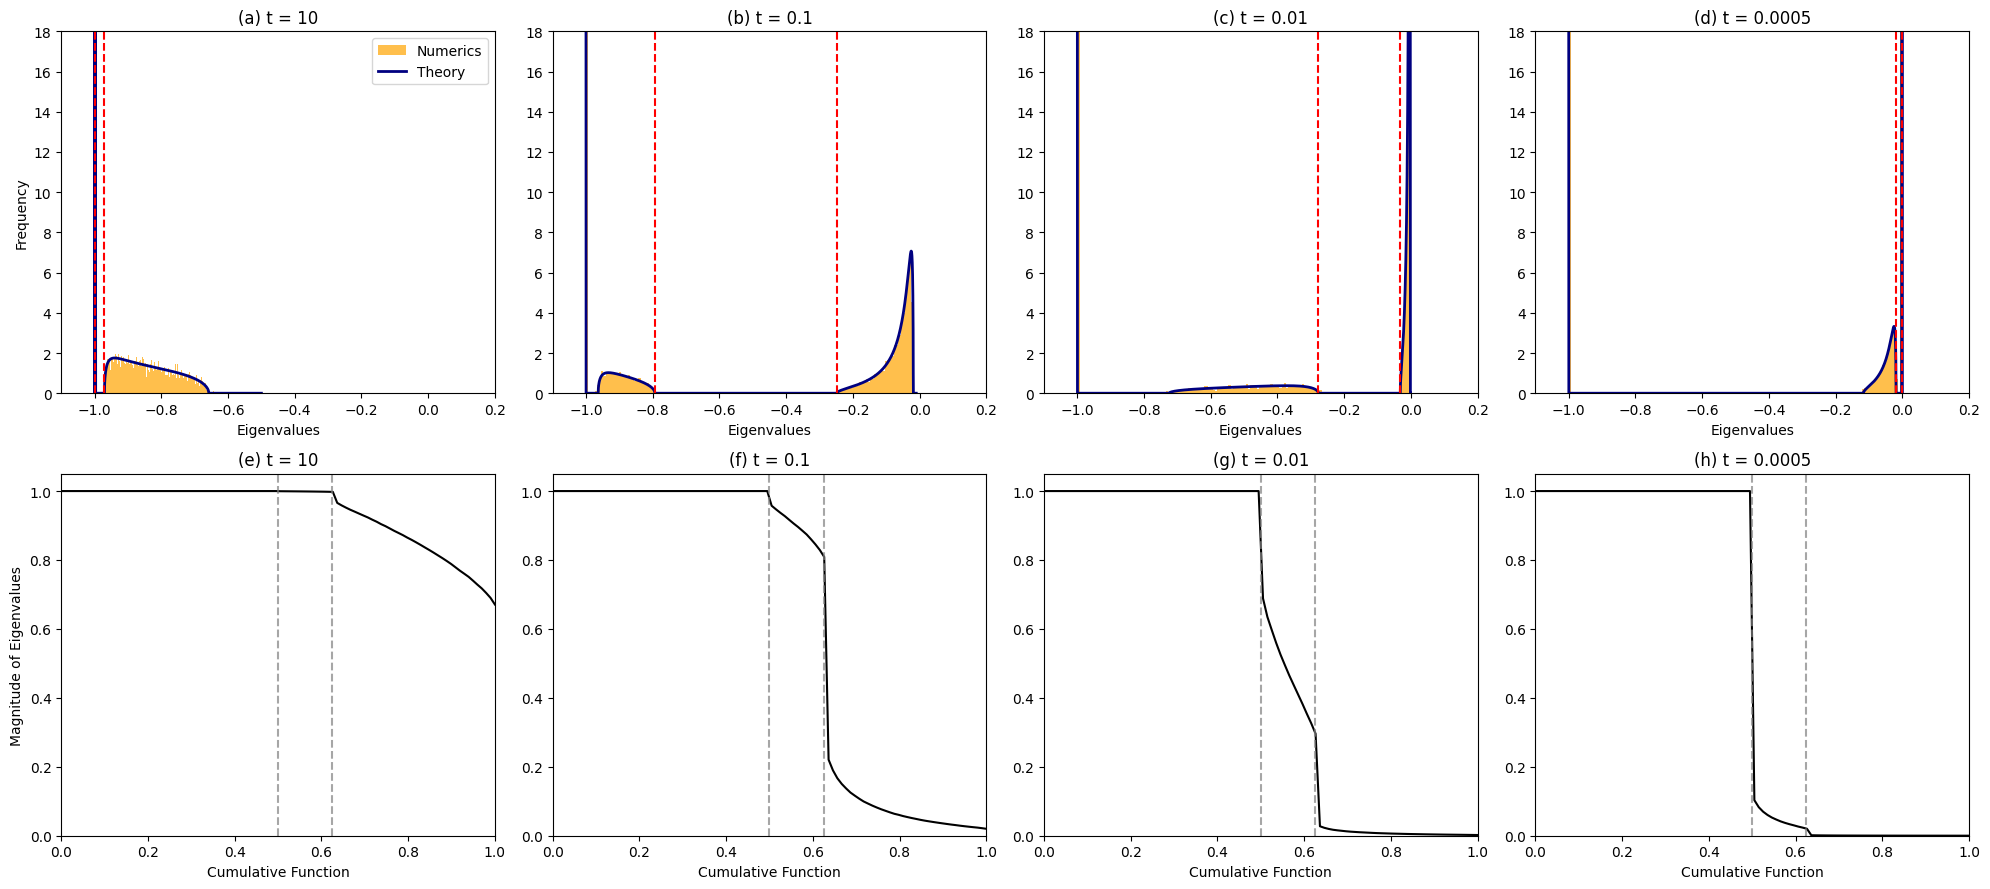

In [6]:
# hyperparamètres
d = 100
alpha = 0.5 
m = int(d * alpha)
s1 = 1.0
s2 = 0.01
f = 0.75
T = [10, 0.1, 0.01, 5e-4]
nb_realisations = 100

# Bornes du gap
g_minus, g_plus = find_gap_bounds(alpha, f, s1, s2)
print(f"Bornes gamma: [{g_minus:.4f}, {g_plus:.4f}]")

# Spectre théorique (calculé une seule fois)
gamma_vals = np.geomspace(1e-12, 10, 10000)
rho_gamma = compute_spectrum(gamma_vals, alpha, f, s1, s2)

# Plot
fig, axes = plt.subplots(2, 4, figsize=(20, 9))

for i, t in enumerate(T):
    print(f"t = {t}...")
    
    # simulation monte carlo
    all_eigs = []
    m1, m2 = int(m * f), m - int(m * f)
    for _ in range(nb_realisations):
        F1 = np.random.normal(0, np.sqrt(s1/m), (d, m1))
        F2 = np.random.normal(0, np.sqrt(s2/m), (d, m2))
        F = np.hstack([F1, F2])
        FtF = F.T @ F
        J_t = (1/t) * F @ np.linalg.solve(np.eye(m) + (1/t)*FtF, F.T) - np.eye(d)
        all_eigs.append(np.linalg.eigvalsh(J_t))
    
    all_eigs = np.array(all_eigs)
    eigs_num = all_eigs.flatten()

    # théorie
    r_vals, rho_J = transform_spectrum_to_J(gamma_vals, rho_gamma, t)
    r_minus, r_plus = transform_bounds_to_J_approx(g_minus, g_plus, t)

    # Plot densité
    ax_top = axes[0, i]
    ax_top.hist(eigs_num, bins=150, density=True, color='orange', alpha=0.7, label='Numerics')
    ax_top.plot(r_vals, rho_J, 'navy', lw=2, label='Theory')
    ax_top.axvline(r_minus, color='red', ls='--', lw=1.5)
    ax_top.axvline(r_plus, color='red', ls='--', lw=1.5)
    ax_top.set_title(f"({chr(97+i)}) t = {t}")
    ax_top.set_xlim(-1.1, 0.2)
    ax_top.set_ylim(0, 18)
    ax_top.set_xlabel("Eigenvalues")
    if i == 0: 
        ax_top.set_ylabel("Frequency")
        ax_top.legend()

    # Plot CDF
    ax_bot = axes[1, i]
    sorted_per_run = np.sort(np.abs(all_eigs), axis=1)[:, ::-1]
    mean_sorted_mag = np.mean(sorted_per_run, axis=0)
    mean_sorted_mag_normalized = mean_sorted_mag / np.max(mean_sorted_mag)
    cumulative_x = np.linspace(0, 1, d)
    
    ax_bot.plot(cumulative_x, mean_sorted_mag_normalized, 'k-', lw=1.5)
    ax_bot.axvline(x=alpha, color='gray', ls='--', alpha=0.7)
    ax_bot.axvline(x=alpha + (1-f)*alpha, color='gray', ls='--', alpha=0.7)
    ax_bot.set_xlim(0, 1.0)
    ax_bot.set_ylim(0, 1.05)
    ax_bot.set_xlabel("Cumulative Function")
    ax_bot.set_title(f"({chr(101+i)}) t = {t}")
    if i == 0:
        ax_bot.set_ylabel("Magnitude of Eigenvalues")

plt.tight_layout()
plt.show()

# Figure 10

In [7]:
if torch.backends.mps.is_available():
    device =  torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

torch.manual_seed(42)
np.random.seed(42)

mps


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.act = nn.SiLU()

    def forward(self, x):
        h = self.act(self.fc1(x))
        h = self.fc2(h)
        return x + h

class ToyScoreModel(nn.Module):
    def __init__(self, d=100, hidden_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.input_proj = nn.Linear(d, hidden_dim)
        self.res1 = ResidualBlock(hidden_dim)
        self.res2 = ResidualBlock(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, d)
        self.act = nn.SiLU()

    def forward(self, x, t):
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        t_emb = self.time_mlp(t)
        h = self.input_proj(x)
        h = h + t_emb
        h = self.res1(h)
        h = self.res2(h)
        h = self.act(h)
        return self.output_proj(h)

In [9]:
def generate_ellipsoid_data(n_samples, d, m, sigma1_sq, sigma2_sq, f):
    """data for Appendix D"""
    n1 = int(f * m)
    n2 = m - n1
    
    # F projection matrix
    F1 = torch.randn(d, n1) * np.sqrt(sigma1_sq / m)
    F2 = torch.randn(d, n2) * np.sqrt(sigma2_sq / m)
    F = torch.cat([F1, F2], dim=1).to(device)
    
    # Latent z
    z = torch.randn(n_samples, m).to(device)
    # Projection sur la sphère (Appendix D)
    z_norms = torch.norm(z, dim=1, keepdim=True)
    z_tilde = z / (z_norms + 1e-8)
    
    y = z_tilde @ F.T
    return y, F

def train_model(data, epochs=20000, batch_size=256, t_min=1e-4, t_max=1.0):
    d = data.shape[1]
    # Correction: hidden_dim=128
    model = ToyScoreModel(d=d, hidden_dim=128).to(device) 
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    n_samples = data.shape[0]
    model.train()
    
    for epoch in range(epochs):
        idx = torch.randint(0, n_samples, (batch_size,), device=device)
        x0 = data[idx]
        
        # Sampling t (Log-uniform est standard pour Score Matching)
        log_t = torch.rand(batch_size, 1, device=device) * (np.log(t_max) - np.log(t_min)) + np.log(t_min)
        t = torch.exp(log_t)
        
        # Variance Exploding: sigma(t) = sqrt(t) -> variance t
        eps = torch.randn_like(x0)
        x_t = x0 + torch.sqrt(t) * eps
        
        # Target score for VE SDE: -eps / sigma(t)
        target = -eps / torch.sqrt(t)
        pred = model(x_t, t)
        
        # Loss weighting lambda(t) = sigma(t)^2 = t
        loss = ((pred - target) ** 2 * t).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

def get_orthogonal_perturbations(d, device):
    q, _ = torch.linalg.qr(torch.randn(d, d))
    return q.to(device)

def algorithm_2(model, x0, t0, eps=1e-3):
    """Algorithme 2 avec normalisation"""
    model.eval()
    device = x0.device
    d = x0.numel()
    
    q_matrix = get_orthogonal_perturbations(d, device)
    x0_expanded = x0.unsqueeze(0).expand(d, -1)
    
    # Perturbations orthogonales symétriques
    # Note: q_matrix.T car les vecteurs sont en colonnes dans Q
    perturbations = q_matrix.T 
    x_pos = x0_expanded + eps * perturbations
    x_neg = x0_expanded - eps * perturbations
    
    t_tensor = torch.full((d, 1), t0, device=device, dtype=torch.float32)
    
    with torch.no_grad():
        score_pos = model(x_pos, t_tensor)
        score_neg = model(x_neg, t_tensor)
    
    # Approximation Jacobien
    diff = (score_pos - score_neg) / (2 * eps)
    
    # SVD
    _, s_values, _ = torch.linalg.svd(diff.cpu()) 
    s_np = s_values.numpy()
    
    # 1. Retirer la première valeur (divergente) 
    if len(s_np) > 1:
        s_np = s_np[1:]
        
    # 2. Normalisation 
    if s_np.max() > 0:
        s_np = s_np / s_np.max()
        
    return s_np

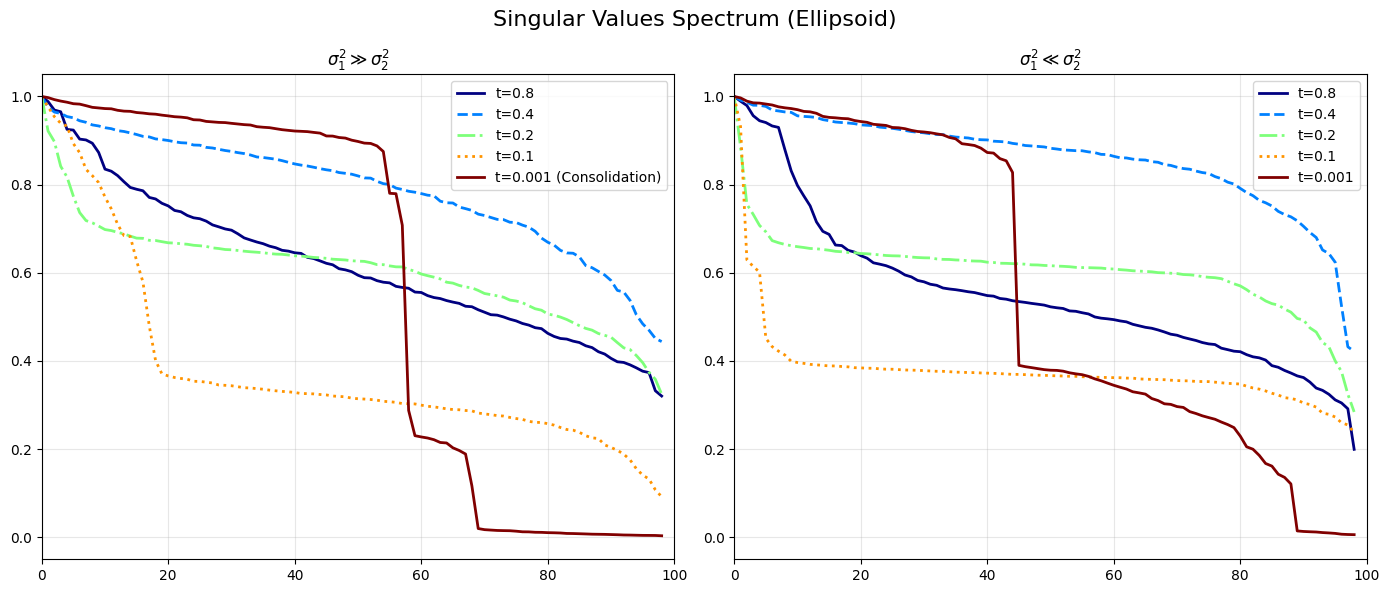

In [10]:
# Paramètres
d = 100
m = 40
f = 0.75
n_samples = 100000
epochs = 30000 

# Temps à tester (Phase couverture -> Consolidation)
t_values = [0.8, 0.4, 0.2, 0.1, 0.001]

# (σ₁² >> σ₂²)
data_left, _ = generate_ellipsoid_data(n_samples, d, m, sigma1_sq=1.0, sigma2_sq=0.01, f=f)
model_left = train_model(data_left, epochs=epochs)

spectra_left = {}
x_test_left = data_left[0]
for t in t_values:
    spectra_left[t] = algorithm_2(model_left, x_test_left, t)

# (σ₁² << σ₂²)
data_right, _ = generate_ellipsoid_data(n_samples, d, m, sigma1_sq=0.01, sigma2_sq=1.0, f=f)
model_right = train_model(data_right, epochs=epochs)

spectra_right = {}
x_test_right = data_right[0]
for t in t_values:
    spectra_right[t] = algorithm_2(model_right, x_test_right, t)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.jet(np.linspace(0, 1, len(t_values)))
line_styles = ['-', '--', '-.', ':', '-']

# Subplot 1 (Left)
ax = axes[0]
for i, t in enumerate(t_values):
    lbl = f't={t}' + (' (Consolidation)' if t<=0.001 else '')
    ax.plot(spectra_left[t], color=colors[i], linestyle=line_styles[i], linewidth=2, label=lbl)

ax.set_title(r"$\sigma_1^2\gg \sigma_2^2$")
ax.set_ylim(-0.05, 1.05); ax.set_xlim(0, d)
ax.legend()
ax.grid(True, alpha=0.3)

# Subplot 2 (Right)
ax = axes[1]
for i, t in enumerate(t_values):
    lbl = f't={t}'
    ax.plot(spectra_right[t], color=colors[i], linestyle=line_styles[i], linewidth=2, label=lbl)

ax.set_title(r"$\sigma_1^2\ll \sigma_2^2$")
ax.set_ylim(-0.05, 1.05); ax.set_xlim(0, d)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle("Singular Values Spectrum (Ellipsoid)", fontsize=16)
plt.tight_layout()
plt.show()

# Figure 5

In [11]:
model= UNet2DModel.from_pretrained("1aurent/ddpm-mnist").to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


In [12]:
# (Stanczuk et al. 2022)
def get_spectrum_standard(model, x0, t_index, device, epsilon=1e-3, batch_size=128):
    model.eval()
    d = x0.numel()
    
    perturbations = torch.randn(d, *x0.shape[1:], device=device)
    perturbations = perturbations / perturbations.view(d, -1).norm(dim=1, keepdim=True).view(d, 1, 1, 1)
    
    x0_expanded = x0.expand(d, -1, -1, -1)
    x_perturbed = x0_expanded + epsilon * perturbations
    t_tensor = torch.full((d,), t_index, device=device, dtype=torch.long)

    outputs = []
    with torch.no_grad():
        for i in range(0, d, batch_size):
            end = min(i + batch_size, d)
            out = model(x_perturbed[i:end], t_tensor[i:end]).sample
            outputs.append(out)
            
    eps_out = torch.cat(outputs, dim=0)
    
    with torch.no_grad():
        score_x0 = model(x0, torch.tensor([t_index], device=device)).sample
    
    diff = (eps_out - score_x0) / epsilon
    jacobian_matrix = diff.view(d, -1).cpu()
    
    _, S, _ = torch.linalg.svd(jacobian_matrix, full_matrices=False)
    S_np = S.numpy()
    
    return S_np / S_np.max() if S_np.max() > 0 else S_np


# méthode du papier
def get_spectrum_orthogonalized(model, x0, t_index, device, epsilon=1e-3, batch_size=128):
    model.eval()
    d = x0.numel()
    
    noise_matrix = torch.randn(d, d, device='cpu')
    q, _ = torch.linalg.qr(noise_matrix)
    q = q.to(device)
    perturbations = q.view(d, *x0.shape[1:])
    
    x0_expanded = x0.expand(d, -1, -1, -1)
    x_pos = x0_expanded + epsilon * perturbations
    x_neg = x0_expanded - epsilon * perturbations
    t_tensor = torch.full((d,), t_index, device=device, dtype=torch.long)

    outputs_pos, outputs_neg = [], []
    with torch.no_grad():
        for i in range(0, d, batch_size):
            end = min(i + batch_size, d)
            out_p = model(x_pos[i:end], t_tensor[i:end]).sample
            out_n = model(x_neg[i:end], t_tensor[i:end]).sample
            outputs_pos.append(out_p)
            outputs_neg.append(out_n)
            
    eps_pos = torch.cat(outputs_pos, dim=0)
    eps_neg = torch.cat(outputs_neg, dim=0)
    
    diff = (eps_pos - eps_neg) / 2 ###
    jacobian_matrix = diff.view(d, -1).cpu()
    
    _, S, _ = torch.linalg.svd(jacobian_matrix, full_matrices=False)
    S_np = S.numpy()
    
    return S_np / S_np.max() if S_np.max() > 0 else S_np

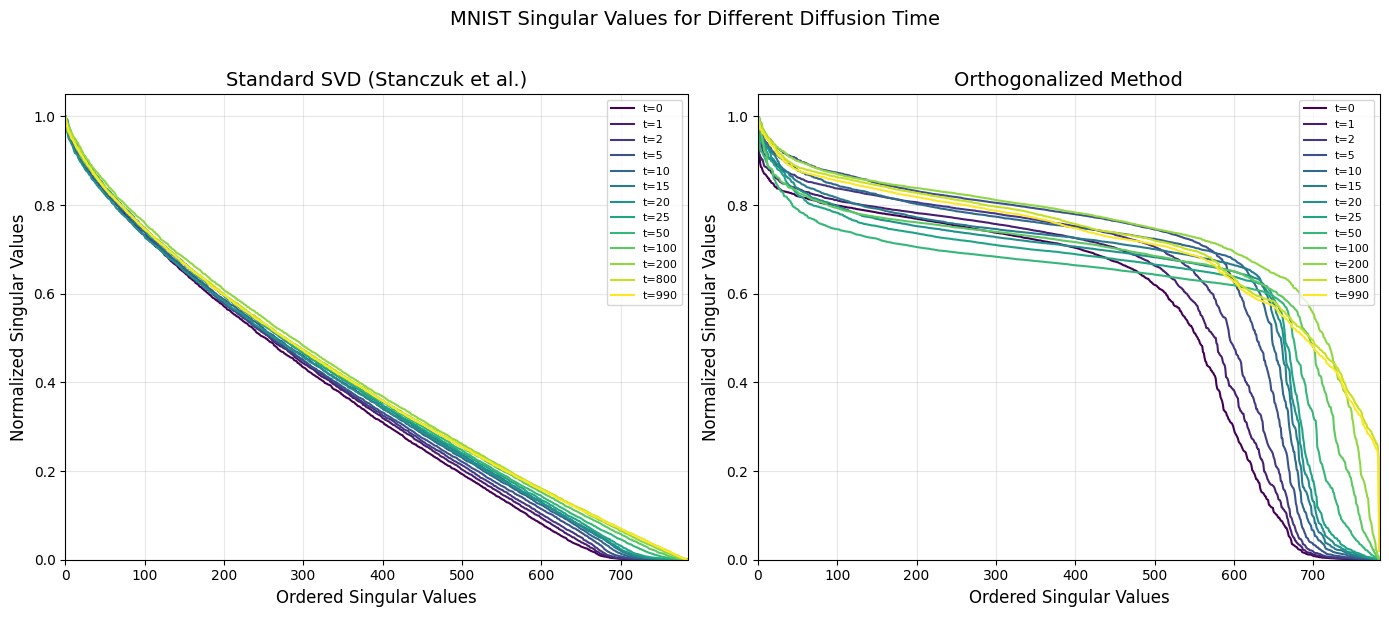

In [13]:
# Figure 9
image, label = dataset[0]
image = image.unsqueeze(0).to(device)

times = [0, 1, 2, 5, 10, 15, 20, 25, 50, 100, 200, 800, 990]
    
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap = plt.cm.viridis(np.linspace(0, 1, len(times)))

d = image.numel()

for t, color in zip(times, cmap):
    
    # Méthode standard
    spectrum_std = get_spectrum_standard(model, image, t, device)
    axes[0].plot(np.arange(len(spectrum_std)), spectrum_std, 
                    color=color, lw=1.5, label=f't={t}')
    
    # Méthode orthogonalisée
    spectrum_orth = get_spectrum_orthogonalized(model, image, t, device, epsilon=0.0148)
    axes[1].plot(np.arange(len(spectrum_orth)), spectrum_orth, 
                    color=color, lw=1.5, label=f't={t}')

# plot
for ax, title in zip(axes, ['Standard SVD (Stanczuk et al.)', 'Orthogonalized Method']):
    ax.set_xlabel("Ordered Singular Values", fontsize=12)
    ax.set_ylabel("Normalized Singular Values", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xlim(0, d)
    ax.set_ylim(0, 1.05)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle("MNIST Singular Values for Different Diffusion Time", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

l'algo du papier apprend bien la dimension de la manifold contrairement à l'algo standard SVD